<a href="https://colab.research.google.com/github/nmarth2993/cmsc655-project/blob/Theo's-code/MVLinRreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install chess

In [4]:
#two ways of  representing results:


# 1)
#in terms of white and black

# 0 - black wins
# .5 - draw
# 1 - white wins
# evaluation is signed (# e.g. +3.21 means white is winning, negative number means black is winning)


# 2)
# in terms of the person who made the current move and the opponent

# 0 - opponent wins
# .5 - draw
# 1 - player wins
# evaluation is unsigned


# if each row is a half-move, how can you possibly use the former method



In [30]:
import chess.pgn
import pandas as pd

def parse_pgn_file(file_path):
    games = []
    games_missing_headers = []

    with open(file_path, 'r') as f:
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break

            # Check if the necessary headers are present
            if 'Result' not in game.headers or 'WhiteElo' not in game.headers or 'BlackElo' not in game.headers:
                games_missing_headers.append(game)
            else:
                games.append(game)

    return games, games_missing_headers

def create_dataset(games):
    data = []

    for game in games:
        board = game.board()

        # Get header information if available
        result = game.headers.get('Result')
        white_elo = int(game.headers.get('WhiteElo', 0))  # Default to 0 if not present
        black_elo = int(game.headers.get('BlackElo', 0))  # Default to 0 if not present

        previous_eval = None  # To store the previous evaluation

        for node in game.mainline():
            move = node.move
            move_san = board.san(move)
            move_number = board.ply()

            # Determine if the move was played by White or Black
            if board.turn == chess.WHITE:
                player = 'White'
            else:
                player = 'Black'

            # Get Stockfish evaluation from the comment after the move
            comment = node.comment
            stockfish_eval = float(comment.split(' ')[-1]) if comment else None

            # Calculate cp_loss (change in evaluation from the previous move)
            # (usually when centipawn loss is calculated it's always a positive number, but here it makes sense to keep negative centipawn loss for white if we're going w/ absolute_game_result like they did in the paper
            #
            cp_loss = stockfish_eval - previous_eval if previous_eval is not None else None

            # Update the previous_eval for the next iteration
            previous_eval = stockfish_eval

            # Determine the game result w/r/t the player who played the move
            # (1: player wins, 0.5: Draw, 0: opponent wins)
            # absolute_game_result is 1 if white wins, 0.5 draw, 0 if black wins
            # most likely absolute_game_result is the one we'll use, since it matches what they did in the paper
            if result == '1-0' and player == 'White':
                player_game_result = 1
                absolute_game_result = 1
            elif result == '1-0' and player == 'Black':
                player_game_result = 0
                absolute_game_result = 1
            elif result == '1/2-1/2':
                player_game_result = 0.5
                absolute_game_result = 0.5
            elif result == '0-1' and player == 'White':
                player_game_result = 0
                absolute_game_result = 0
            elif result == '0-1' and player == 'Black':
                player_game_result = 1
                absolute_game_result = 0
            else:  # there really shouldn't be an else if the pgns are all correct
                player_game_result = None

            data.append({
                'Move': move_san,
                'MoveNumber': move_number,
                'Player': player,
                'WhiteElo': white_elo,
                'BlackElo': black_elo,
                'GameResult': player_game_result,
                'AbsGameResult': absolute_game_result,
                'StockfishEval': stockfish_eval,
                'cp_loss': cp_loss
            })

            board.push(move)

    return pd.DataFrame(data)

pgn_file_path = 'drive/MyDrive/db2k.pgn' # just use whatever your path is to the pgn
games, games_missing_headers = parse_pgn_file(pgn_file_path)

# Create the dataset w/out the games with missing headers
dataset = create_dataset(games)
print(dataset.head())


  Move  MoveNumber Player  WhiteElo  BlackElo  GameResult  AbsGameResult  \
0   e4           0  White      2372      2419         0.5            0.5   
1   c5           1  Black      2372      2419         0.5            0.5   
2  Nf3           2  White      2372      2419         0.5            0.5   
3  Nc6           3  Black      2372      2419         0.5            0.5   
4   d4           4  White      2372      2419         0.5            0.5   

   StockfishEval  cp_loss  
0           0.22      NaN  
1           0.42     0.20  
2           0.34    -0.08  
3           0.35     0.01  
4           0.20    -0.15  


In [31]:
print(dataset.head(100))

     Move  MoveNumber Player  WhiteElo  BlackElo  GameResult  AbsGameResult  \
0      e4           0  White      2372      2419         0.5            0.5   
1      c5           1  Black      2372      2419         0.5            0.5   
2     Nf3           2  White      2372      2419         0.5            0.5   
3     Nc6           3  Black      2372      2419         0.5            0.5   
4      d4           4  White      2372      2419         0.5            0.5   
..    ...         ...    ...       ...       ...         ...            ...   
95    Qg4          58  White      2188      2361         0.0            0.0   
96    Ra1          59  Black      2188      2361         1.0            0.0   
97   Rxa1          60  White      2188      2361         0.0            0.0   
98  Qxa1+          61  Black      2188      2361         1.0            0.0   
99    Nf1          62  White      2188      2361         0.0            0.0   

    StockfishEval  cp_loss  
0            0.22     

In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Drop rows with NaN values
dataset_cleaned = dataset.dropna()

# Drop the "Move" and "Player" variables
dataset_cleaned = dataset_cleaned.drop(columns=['Move', 'Player'])

# Reset index to ensure consistency
dataset_cleaned = dataset_cleaned.reset_index(drop=True)

# Extract features
features = ['WhiteElo', 'BlackElo', 'GameResult', 'StockfishEval', 'cp_loss', 'MoveNumber']

# Extract the features and scale them
X_scaled = pd.DataFrame(StandardScaler().fit_transform(dataset_cleaned[features]), columns=features)

# Combine the scaled numerical features with the rest
X_combined = pd.concat([X_scaled, dataset_cleaned.drop(features, axis=1)], axis=1)

# Extract the target variable with the same index as X_combined
y = dataset_cleaned.loc[X_combined.index, 'AbsGameResult']

# Split the dataset into training and test sets (more for other models aside from the Linear Regression)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Display the shape of the training and test sets
print("Training Set Shape:", X_train.shape, y_train.shape)
print("Test Set Shape:", X_test.shape, y_test.shape)

# Create X_run1 as DataFrame with features StockfishEval, cp_loss, and MoveNumber
X_run1 = X_combined[['StockfishEval', 'cp_loss', 'MoveNumber']]

# Create X_run2 with features StockfishEval and cp_loss
X_run2 = X_combined[['StockfishEval', 'cp_loss']]






Training Set Shape: (142964, 7) (142964,)
Test Set Shape: (35742, 7) (35742,)


In [33]:



import numpy as np

def multivariate_linear_regression_ols(X, y):
    """
    Perform multivariate linear regression using the ordinary least squares (OLS) method.

    Parameters:
    - X: Feature matrix (including intercept term)
    - y: Target vector

    Returns:
    - theta: Coefficients (weights)
    """
    theta = np.linalg.inv(X.T @ X) @ X.T @ y
    return theta

# Example usage:

# Assuming X_combined and y are your combined feature matrix and target variable from the previous code.

# Run 1: Using MoveNumber, StockfishEval, and cp_loss as features

y_np = y.to_numpy()



In [34]:

# Add intercept term to feature matrix (just a column with all ones)

X_run1_with_intercept = pd.concat([pd.Series(1, index=X_run1.index, name='Intercept'), X_run1], axis=1)
X_run2_with_intercept = pd.concat([pd.Series(1, index=X_run2.index, name='Intercept'), X_run2], axis=1)

# Perform multivariate linear regression

# Run 1
theta_run1 = multivariate_linear_regression_ols(X_run1_with_intercept, y_np)
print("Final Parameters (Run 1):")
print(theta_run1)

# Run 2
theta_run2 = multivariate_linear_regression_ols(X_run2_with_intercept, y_np)
print("\nFinal Parameters (Run 2):")
print(theta_run2)

Final Parameters (Run 1):
0    0.532248
1    0.086360
2   -0.016182
3   -0.011764
dtype: float64

Final Parameters (Run 2):
0    0.532248
1    0.086080
2   -0.016089
dtype: float64


In [35]:
X_run1.describe()

,StockfishEval,cp_loss,MoveNumber
count,1.787060e+05,1.787060e+05,1.787060e+05
mean,-7.315919e-18,7.156877e-19,2.671901e-17
std,1.000003e+00,1.000003e+00,1.000003e+00
min,-7.386062e+00,-1.366022e+01,-1.343476e+00
25%,-2.972237e-02,-8.201211e-03,-7.811709e-01
50%,-2.095653e-02,-4.479400e-03,-1.677472e-01
75%,-6.122032e-03,-3.440552e-04,5.479138e-01
max,7.335607e+00,1.387787e+01,5.813134e+00


In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

theta_run1_2d = np.array(theta_run1).reshape(-1, 1)
theta_run2_2d = np.array(theta_run2).reshape(-1, 1)

# Predictions for Run 1
# Feature matrix w/ intercept @ Theta (matrix of coefficients) gives predicted values
y_pred_run1 = X_run1_with_intercept @ theta_run1_2d

# Predictions for Run 2
y_pred_run2 = X_run2_with_intercept @ theta_run2_2d



In [37]:

y_true_values = y_true.iloc[:, 0].values
y_pred_run1_values = y_pred_run1.iloc[:, 0].values
y_pred_run2_values = y_pred_run2.iloc[:, 0].values

# Creating new DataFrames for residuals from the runs
y_residuals1 = pd.DataFrame({'Residuals_Run1': y_true_values - y_pred_run1_values})
y_residuals2 = pd.DataFrame({'Residuals_Run2': y_true_values - y_pred_run2_values})


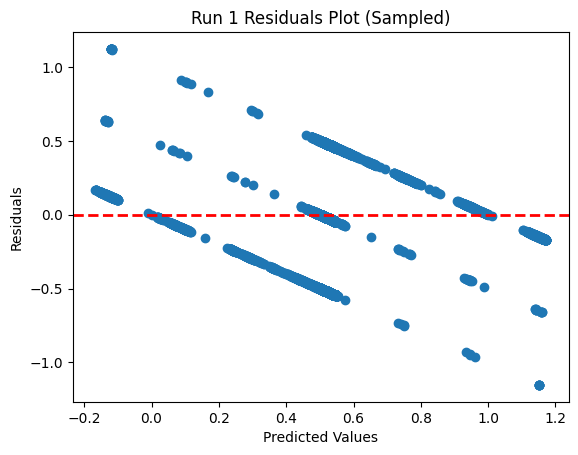

R-squared for Run 1: -1.60569954785218


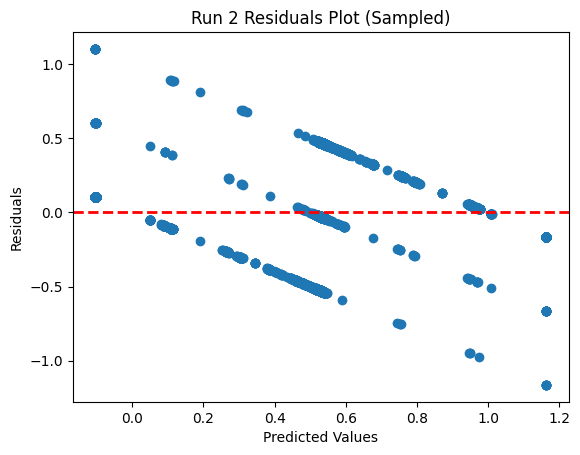

R-squared for Run 2: -1.603705099683003


In [38]:


import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_residuals_sampled(y_residuals, y_pred, title, sample_fraction=1 , random_seed=42):
    np.random.seed(random_seed)

    # Sample a fraction of data points (the sample_fraction parameter can be reduced to do this if the plot is too crowded)
    sample_indices = np.random.choice(len(y_residuals), size=int(sample_fraction * len(y_residuals)), replace=False)

    residuals = y_residuals.iloc[sample_indices, 0]  # Extracting the values from the DataFrame

    plt.scatter(y_pred.iloc[sample_indices, 0], residuals)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.title(f'{title} Residuals Plot (Sampled)')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()



# Plot residuals for Run 1
plot_residuals_sampled(y_residuals1, y_pred_run1, title='Run 1')

# Calculate R-squared for Run 1
r2_run1 = r2_score(y_residuals1.values, y_pred_run1.values)
print(f'R-squared for Run 1: {r2_run1}')

# Plot residuals for Run 2
plot_residuals_sampled(y_residuals2, y_pred_run2, title='Run 2')

# Calculate R-squared for Run 2
r2_run2 = r2_score(y_residuals2.values, y_pred_run2.values)
print(f'R-squared for Run 2: {r2_run2}')
